In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# L2 regularization strengths for grid search on Conv2D layers
regularization_strengths = [0.0001, 0.001, 0.01, 0.1]

best_val_accuracy = 0
best_reg_strength = None
best_model = None

for reg_strength in regularization_strengths:
    print(f"Testing Conv2D L2 regularization with strength {reg_strength}")
    
    tf.keras.backend.clear_session()  # Reset the model state
    model = models.Sequential()

    # Apply L2 regularization with current strength to Conv2D layers
    reg = regularizers.l2(reg_strength)
    model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=reg))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())

    # Fixed L2 regularization for the Dense layer
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile and fit the model as before
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define directory paths for data generators
    train_dir = os.path.join(dataset_folder, 'train')
    validation_dir = os.path.join(dataset_folder, 'validation')

    # Setup data generators
    train_datagen = ImageDataGenerator()
    validation_datagen = ImageDataGenerator()

    batch_size = 32
    target_size = (512, 512)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical')

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical')

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=10,  
        verbose=1  # Set verbose to 1 to see the training progress
    )

    # Evaluate model and update best model if current model is better
    max_val_acc = max(history.history['val_accuracy'])
    if max_val_acc > best_val_accuracy:
        best_val_accuracy = max_val_acc
        best_reg_strength = reg_strength
        best_model = model

print(f"Best Conv2D L2 regularization strength: {best_reg_strength} with validation accuracy: {best_val_accuracy}")

# Optionally, save the best model
# best_model.save('path_to_my_best_model.h5')

# Plot training and validation accuracy and loss
# Your plotting code here



Testing Conv2D L2 regularization with strength 0.0001



Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10


5/5 [==============================] - 27s 5s/step - loss: 2218.2412 - accuracy: 0.3377 - val_loss: 1.3022 - val_accuracy: 0.1875
Epoch 2/10
5/5 [==============================] - 25s 5s/step - loss: 1.2978 - accuracy: 0.3701 - val_loss: 1.3207 - val_accuracy: 0.3125
Epoch 3/10
5/5 [==============================] - 25s 5s/step - loss: 1.3936 - accuracy: 0.3766 - val_loss: 1.4113 - val_accuracy: 0.5312
Epoch 4/10
5/5 [==============================] - 26s 5s/step - loss: 1.4538 - accuracy: 0.4740 - val_loss: 1.4439 - val_accuracy: 0.5625
Epoch 5/10
5/5 [==============================] - 26s 5s/step - loss: 1.5079 - accuracy: 0.5312 - val_loss: 1.5691 - val_accuracy: 0.4688
Epoch 6/10
5/5 [==============================] - 25s 5s/step - loss: 1.5080 - accuracy: 0.5000 - val_loss: 1.4935 - val_accuracy: 0.3438
Epoch 7/10
5/5 [============

Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 26s 5s/step - loss: 1389.4832 - accuracy: 0.4091 - val_loss: 4.1491 - val_accuracy: 0.2188
Epoch 2/10
5/5 [==============================] - 25s 5s/step - loss: 4.3868 - accuracy: 0.4026 - val_loss: 5.0447 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 26s 5s/step - loss: 5.3895 - accuracy: 0.5125 - val_loss: 5.9568 - val_accuracy: 0.3125
Epoch 4/10
5/5 [==============================] - 25s 5s/step - loss: 9.6569 - accuracy: 0.5649 - val_loss: 7.2326 - val_accuracy: 0.3125
Epoch 5/10
5/5 [==============================] - 24s 5s/step - loss: 6.3543 - accuracy: 0.7338 - val_loss: 6.8707 - val_accuracy: 0.4062
Epoch 6/10
5/5 [==============================] - 25s 5s/step - loss: 6.6912 - accuracy: 0.7468 - val_loss: 7.3867 - val_accuracy: 0.3750
Epoch 7/10
5/5 [==============================] - 25s 5s/step - loss: 6.7377 - accuracy:

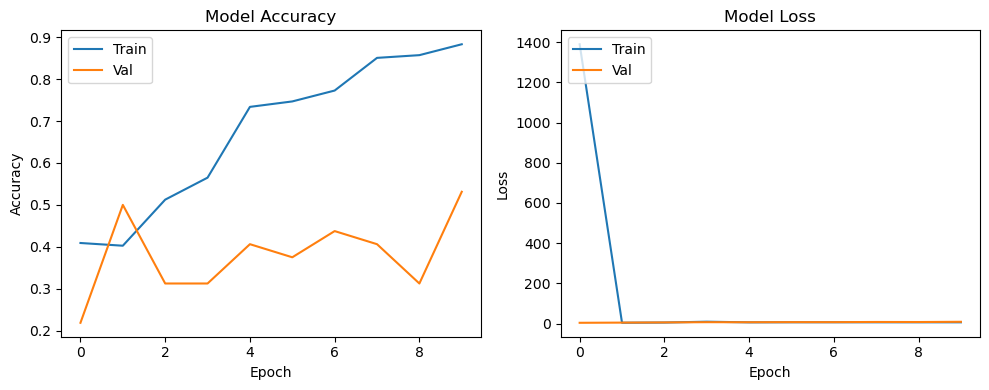

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()
model = models.Sequential()

# Add layers to the model with L2 regularization for the dense layer
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

# Apply L2 regularization with strength 0.01 to the dense layer
model.add(layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step - loss: 8.1143 - accuracy: 0.5312
Test accuracy: 0.53125


Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 26s 5s/step - loss: 2072.9138 - accuracy: 0.3571 - val_loss: 2.6333 - val_accuracy: 0.4688
Epoch 2/10
5/5 [==============================] - 25s 5s/step - loss: 3.2165 - accuracy: 0.3766 - val_loss: 3.9051 - val_accuracy: 0.5312
Epoch 3/10
5/5 [==============================] - 25s 5s/step - loss: 4.3010 - accuracy: 0.4610 - val_loss: 4.7794 - val_accuracy: 0.4375
Epoch 4/10
5/5 [==============================] - 25s 5s/step - loss: 5.0429 - accuracy: 0.5065 - val_loss: 5.3470 - val_accuracy: 0.4688
Epoch 5/10
5/5 [==============================] - 25s 5s/step - loss: 5.4933 - accuracy: 0.5649 - val_loss: 5.8264 - val_accuracy: 0.4688
Epoch 6/10
5/5 [==============================] - 24s 5s/step - loss: 5.7927 - accuracy: 0.6234 - val_loss: 5.9849 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 25s 5s/step - loss: 5.9670 - accuracy:

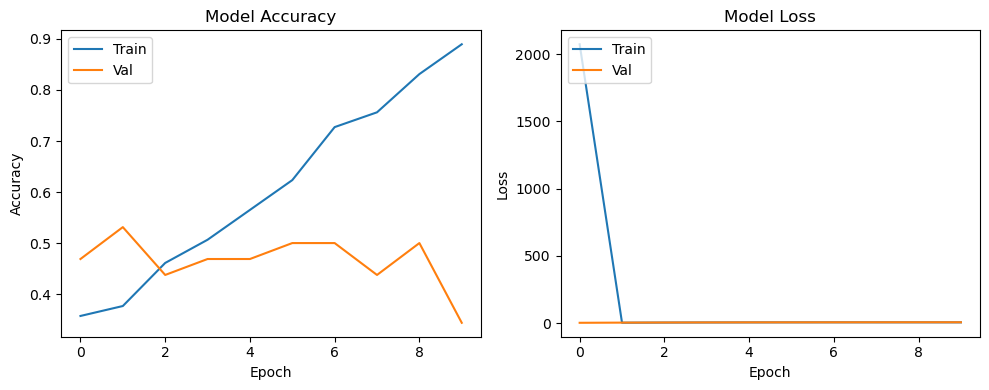

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()
model = models.Sequential()

# Add layers to the model with L2 regularization for the dense layer
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

# Apply L2 regularization with strength 0.01 to the dense layer
model.add(layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step - loss: 6.5822 - accuracy: 0.4688
Test accuracy: 0.46875
